# Load Libraries

In [ ]:
import pandas as pd
import numpy as np
#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

from statsmodels.graphics.gofplots import qqplot
import scipy

<Figure size 432x216 with 0 Axes>

# Load data

In [ ]:
# Remove this code 
import os 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_pickle('train_df')

Get column list based on datatype

In [ ]:
def dtype_sep(df):
  """
  Function returns seperate list of columns of dataframe based on datatype

  Parameter and type: 
    df(Pandas Dataframe): Dataframe

  Return:
    :rtype: Tuple
    :return: Tuple of lists, where each list has the column names of same dtype
  """
  num_cols = []
  obj_cols = []
  date_cols = []
  bool_cols = []
  category_cols = []

  for col in df:
    if df[col].dtype in ['int8','int32','int64','float16','float32','float64']:
      num_cols.append(col)

    elif df[col].dtype == 'object':
      obj_cols.append(col)

    elif df[col].dtype == 'datetime64[ns]':
      date_cols.append(col)

    elif df[col].dtype == 'bool':
      bool_cols.append(col)

    elif df[col].dtype == 'category':
      category_cols.append(col)

  return (num_cols,obj_cols,date_cols,bool_cols,category_cols)

In [ ]:
num_cols,obj_cols,date_cols,bool_cols,category_cols = dtype_sep(train_df)  

## Numerical Column Visualization

### Univariate Analysis

In [ ]:
#Checking basis stats like means, max, min for numerical columns
train_df[num_cols].describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,629090.000000,629090.000000,629090.000000,629090.000000
mean,10767.985503,6253.576208,136.860761,4514.409295
std,11646.153484,8883.346480,147.575975,6473.854152
min,250.000000,-972.120000,0.000000,0.000000
25%,5000.000000,1076.950000,33.660000,689.490000
50%,7500.000000,3188.440000,87.930000,2451.810000
75%,15000.000000,7500.000000,191.220000,5289.350000
max,50000.000000,50000.000000,2011.540000,47498.810000




*   Highest value in the transaction amount is only 2011 USD. Was expecting more higher values.



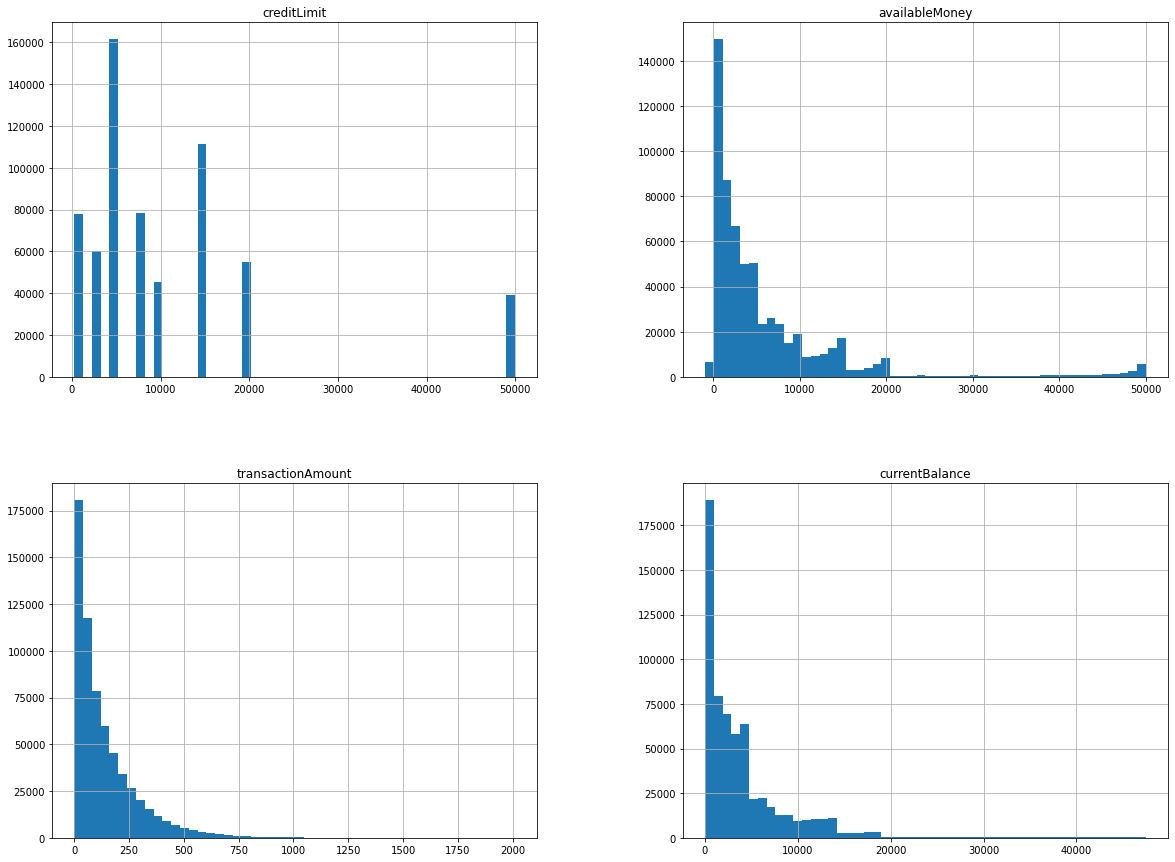

In [ ]:
#Histograms for numerical columns to check distributions
train_df[num_cols].hist(bins=50, figsize=(20,15))
plt.show()



*   Credit Limit has discrete values
*   Available Money, Transaction Amount and Current Balance are right skewed







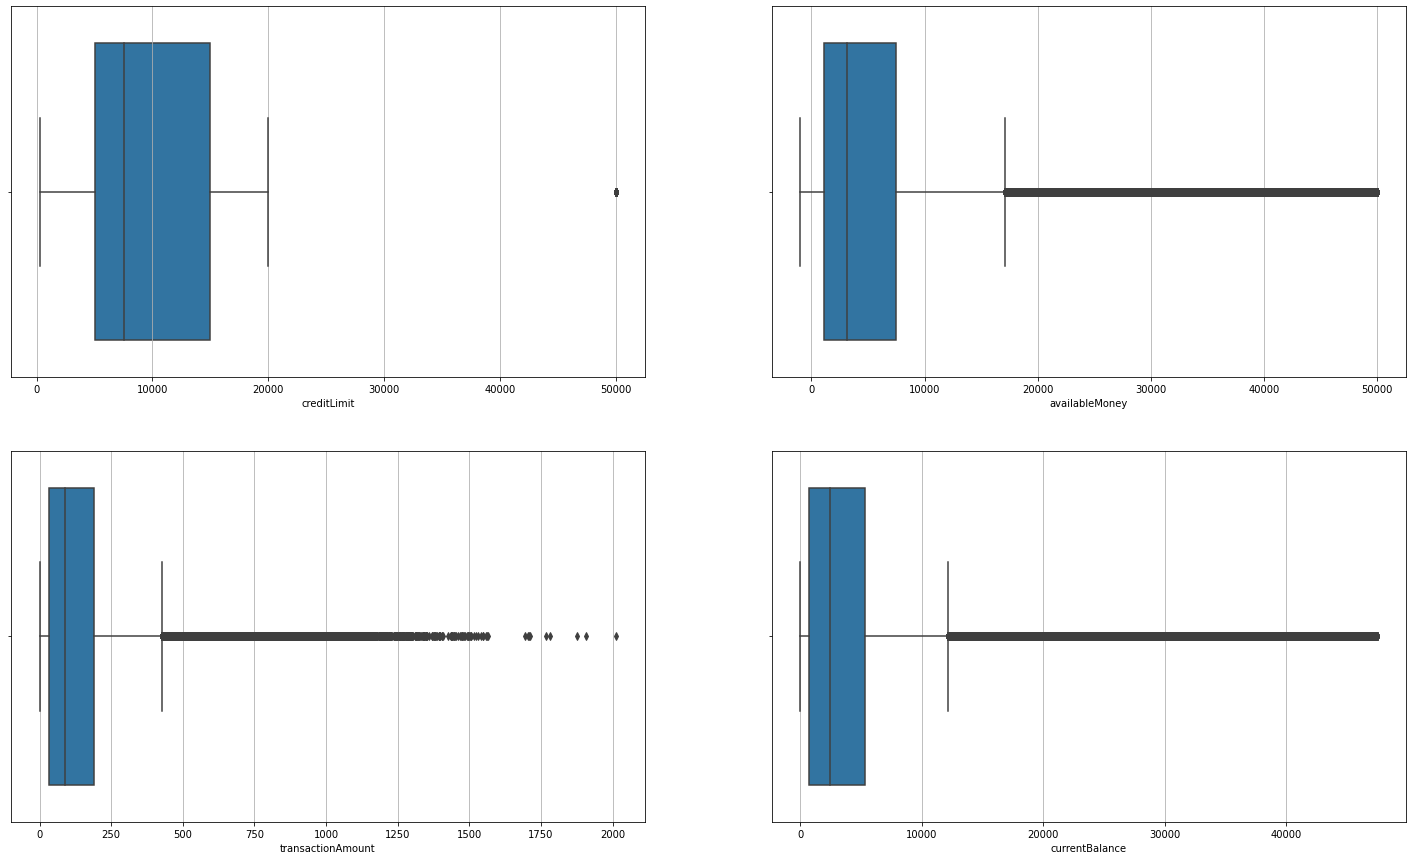

In [ ]:
#Box Plot for numerical columns to check the presence of outliers
dims = (2,2)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in num_cols:
  sns.boxplot(x=col, data=train_df, ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0



*   There are outliers in availablemoney, transactionamount and currentbalance.
*   These outliers can be treated for algorithms like logistic regression, SVM etc.
*   No need for treating outliers in tree based algorithms as they are not sensitive to outliers, no need for treating outliers.







### Transformation

To handle outliers 

In [ ]:
def qq_plot_tr(df, colname):
  # Generate QQ plots
  dims = (3,2)
  f, axes = plt.subplots(dims[0], dims[1], figsize=(15, 18))
  axis_i, axis_j = 0, 0

  for i in [0,1,2,3,4,5]:
    if i==0:
      data_t = np.log(np.clip(df[colname], a_min=0, a_max = None)+1)
    else:
      data_t = np.clip(df[colname], a_min =0, a_max = None)**(1/i)
    ax=axes[axis_i, axis_j]
    qqplot(data_t, line='s', ax=ax)
    ax.set_title("Transformation: 1/{}".format(str(i)))
    axis_j += 1
    if axis_j == dims[1]:
      axis_i += 1
      axis_j = 0
    

In [ ]:
def histogram_tr(df, colname):
  dims = (3,2)
  f, axes = plt.subplots(dims[0], dims[1], figsize=(15, 18))
  axis_i, axis_j = 0, 0

  for i in [0,1,2,3,4,5]:
    if i==0:
      data_t = np.log(np.clip(df[colname], a_min=0, a_max = None)+1)
    else:
      data_t = np.clip(df[colname], a_min =0, a_max = None)**(1/i)

    ax=axes[axis_i, axis_j]
    n, bins, patches = ax.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    ax.plot(bins, scipy.stats.norm.pdf(bins, mu, sigma))
    ax.set_title("Transformation: 1/{}".format(str(i)))
    axis_j += 1
    if axis_j == dims[1]:
      axis_i += 1
      axis_j = 0

##### Transaction Amount

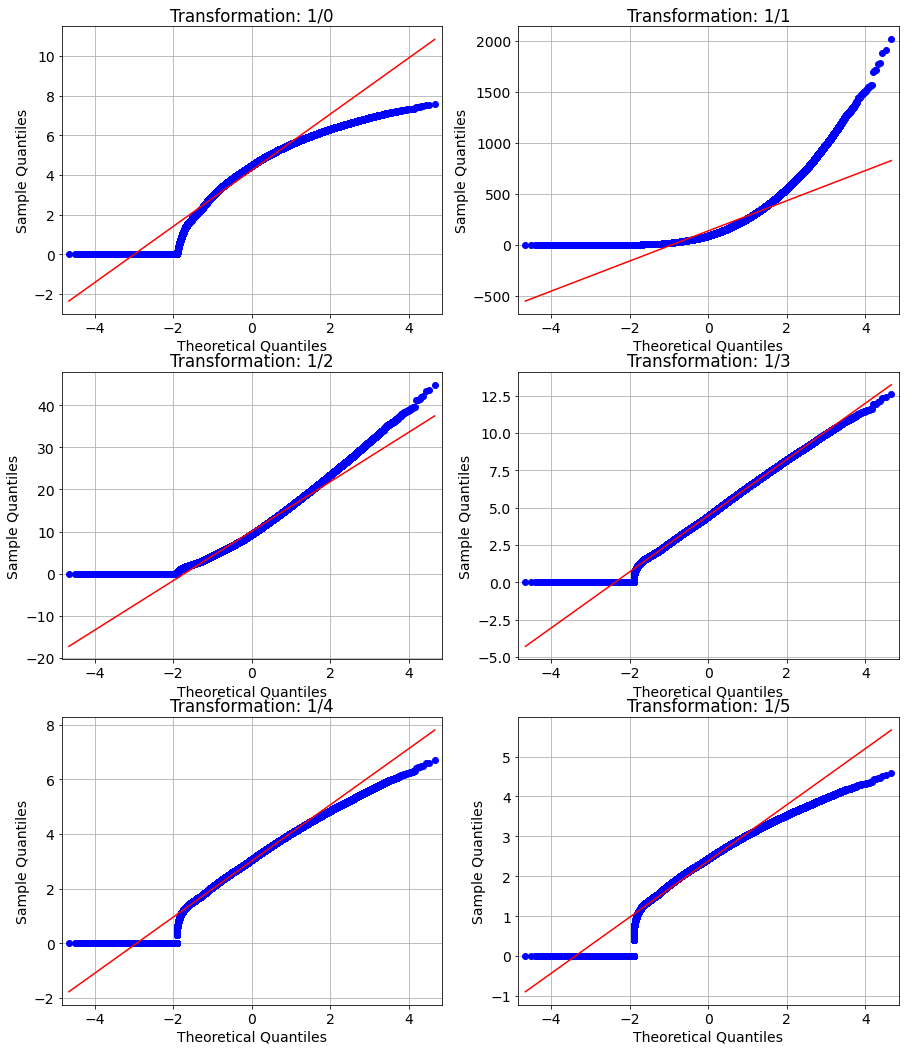

In [ ]:
# Transaction Amount 
qq_plot_tr(train_df, "transactionAmount")

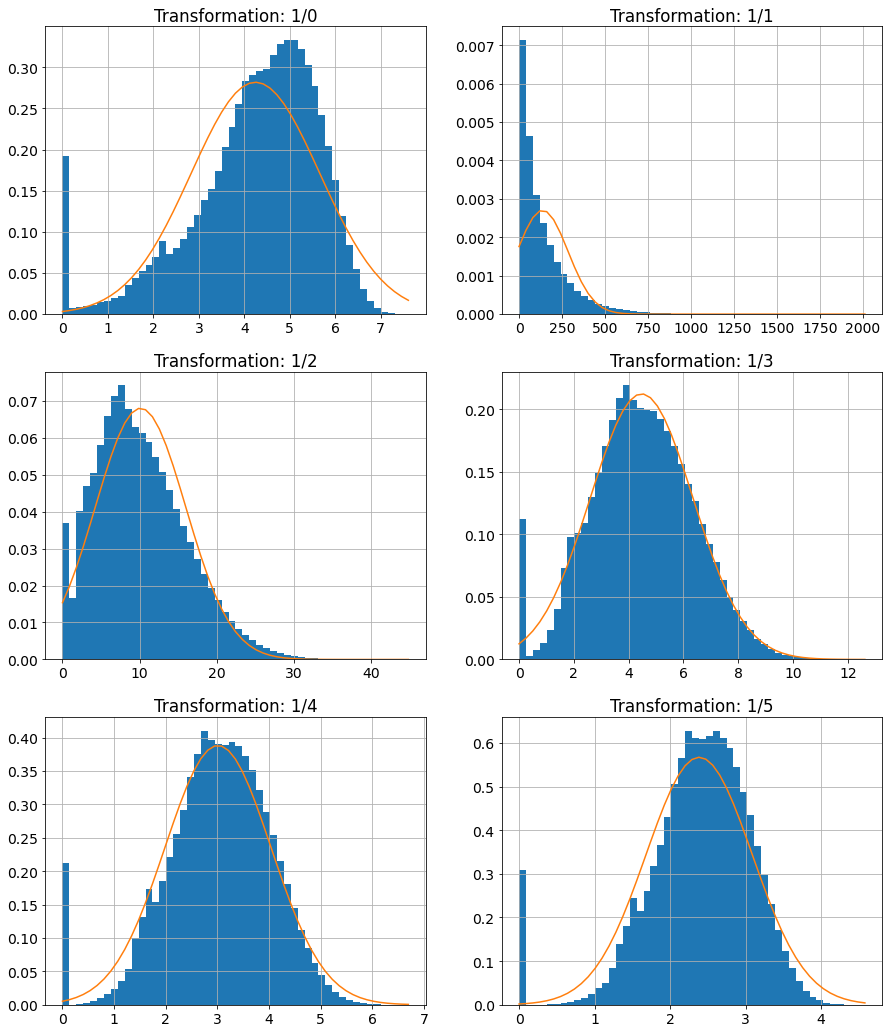

In [ ]:
histogram_tr(train_df, "transactionAmount")

Transcation Amount - Cube root transformation

##### Available Money

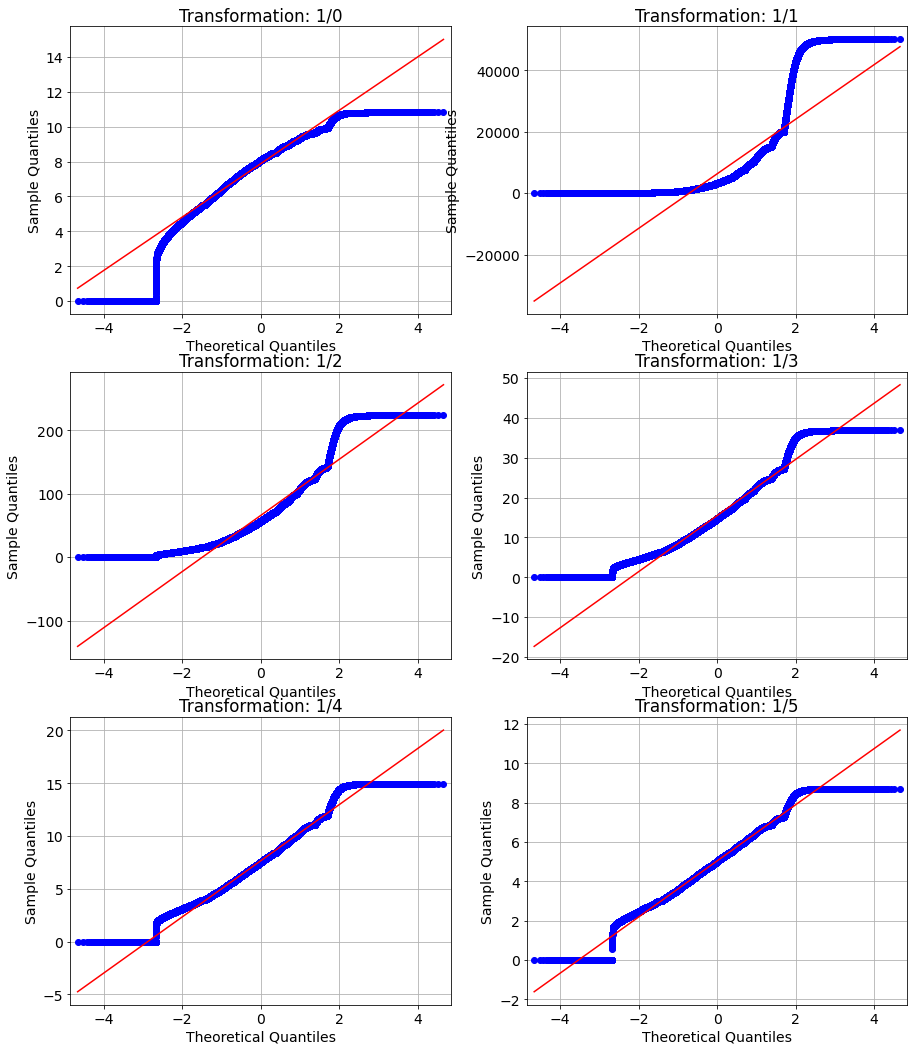

In [ ]:
qq_plot_tr(train_df, "availableMoney")

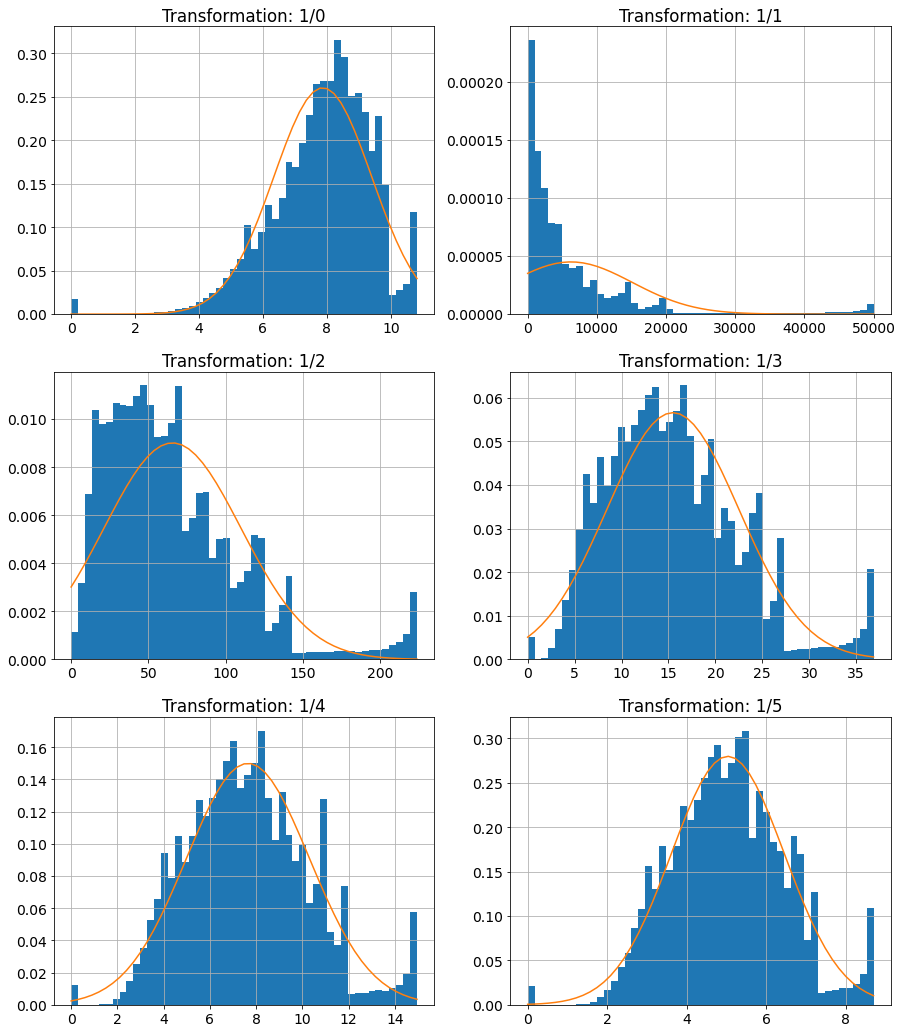

In [ ]:
histogram_tr(train_df, "availableMoney")

Available Money - 1/5 

##### Current Balance

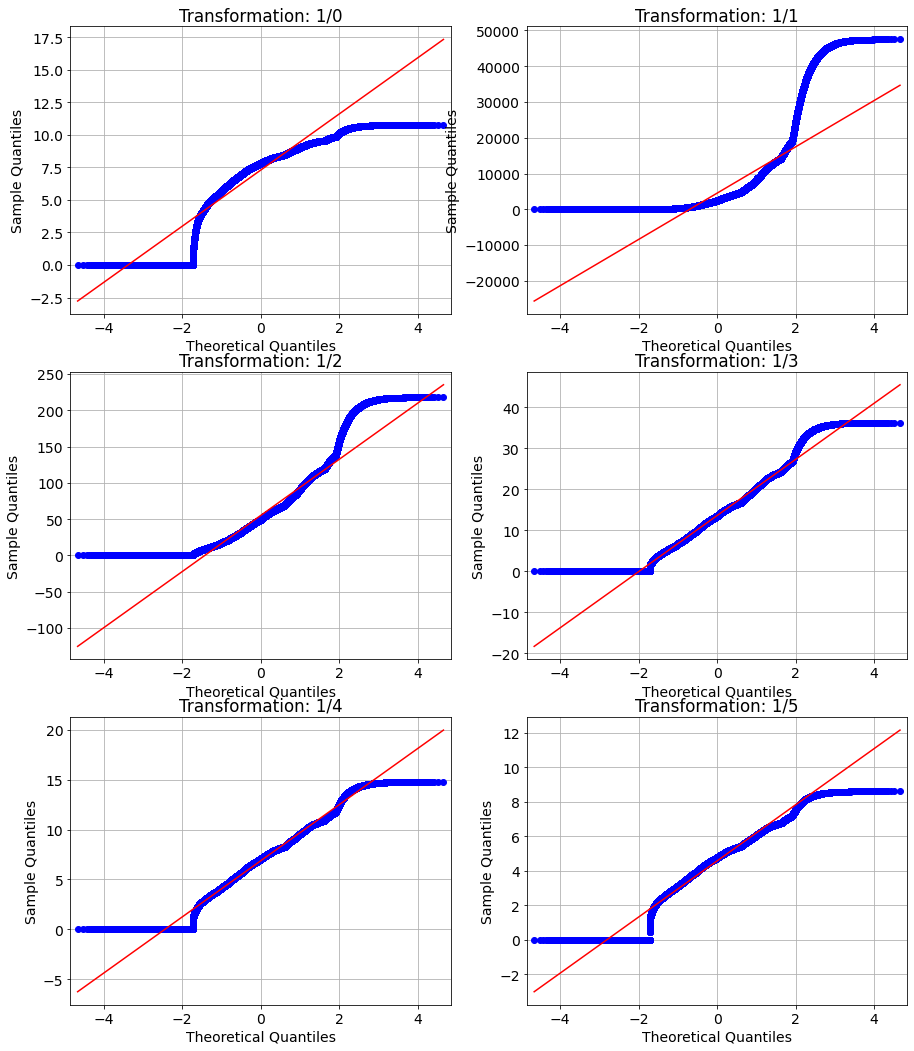

In [ ]:
qq_plot_tr(train_df, "currentBalance")

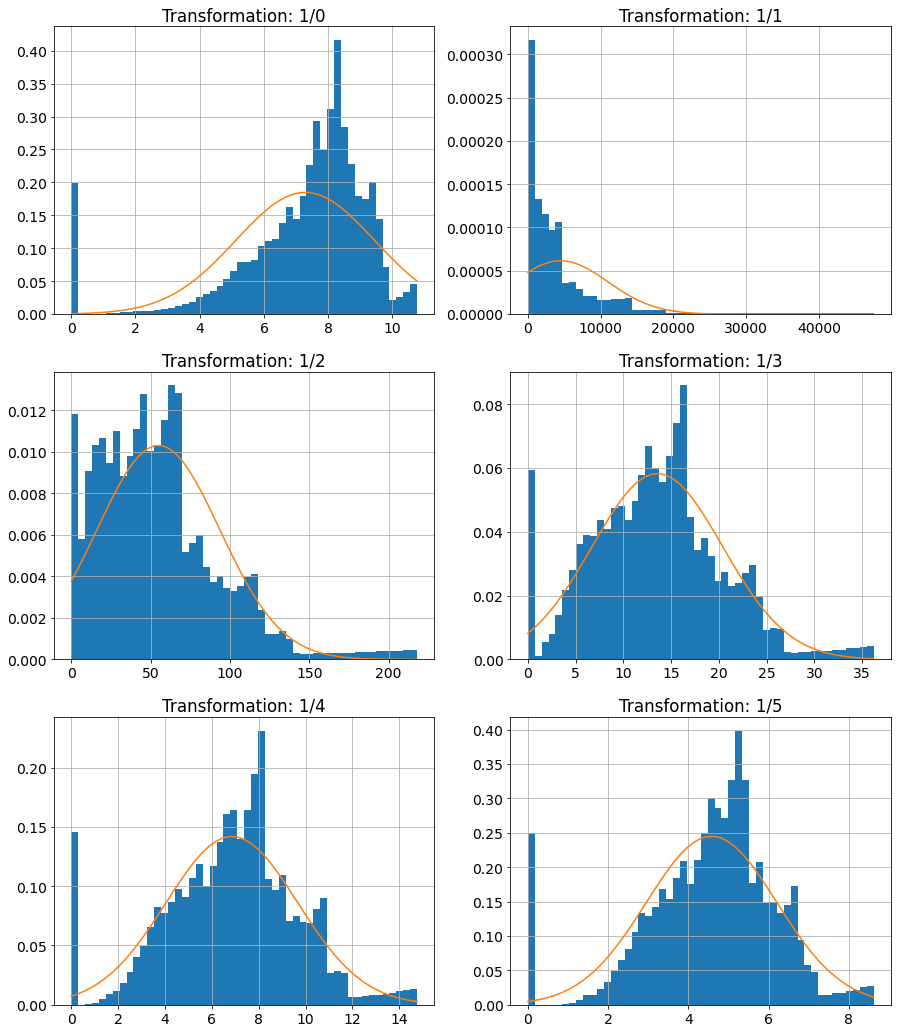

In [ ]:
histogram_tr(train_df, "currentBalance")

Current balance - 1/4

### Bivariate Analysis

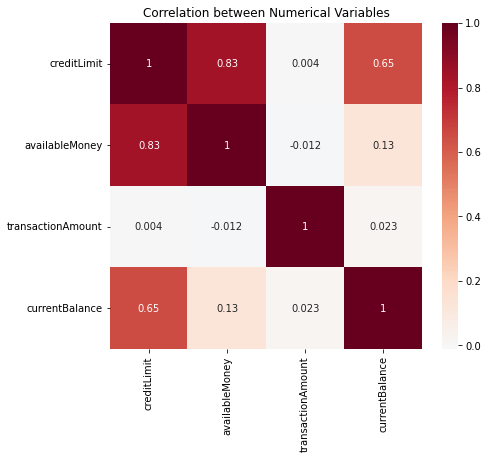

In [ ]:
#correlation between numerical variables

plt.figure(figsize=(7,6))
sns.heatmap(train_df[num_cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between Numerical Variables')
plt.show()



*   Available money and credit limit highly are correlated (0.83)
*   Currentbalance and credit limit are moderately correlated (0.65)
*   Since, Credit Limit = Available Money + Currentbalance. Thus, +ve correlation
*   We can consider dropping one of these 2 in logistic and SVM classifier
*   Since tree based algorithms are roubust to correlation, we can keep both



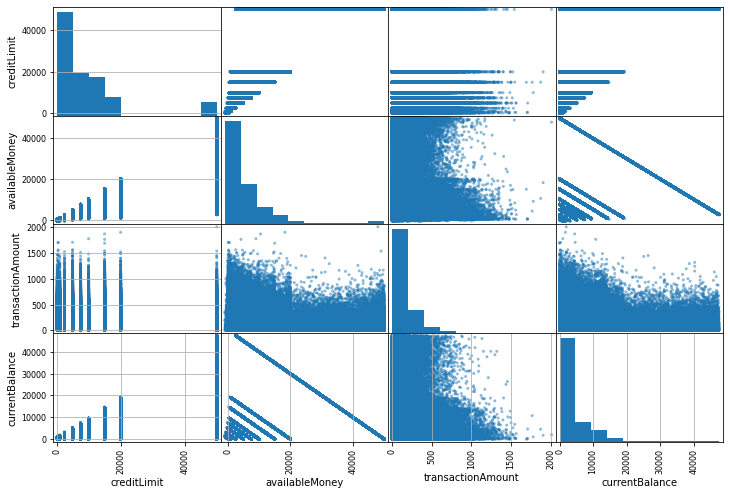

In [ ]:
#Scatter matrix for numerical variables

from pandas.plotting import scatter_matrix

scatter_matrix(train_df[num_cols], figsize=(12, 8))
plt.show()

<Figure size 504x432 with 0 Axes>

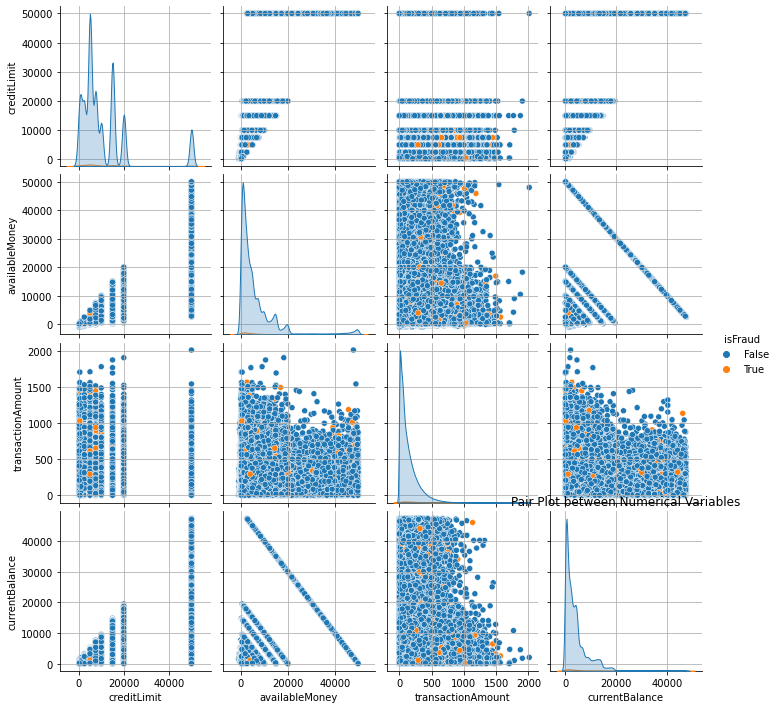

In [ ]:
#Pair plot between numerical using seaborn

plt.figure(figsize=(7,6))

a = num_cols + ['isFraud']
sns.pairplot(train_df[a],hue = 'isFraud')
plt.title('Pair Plot between Numerical Variables')
plt.show()

**No major findings**

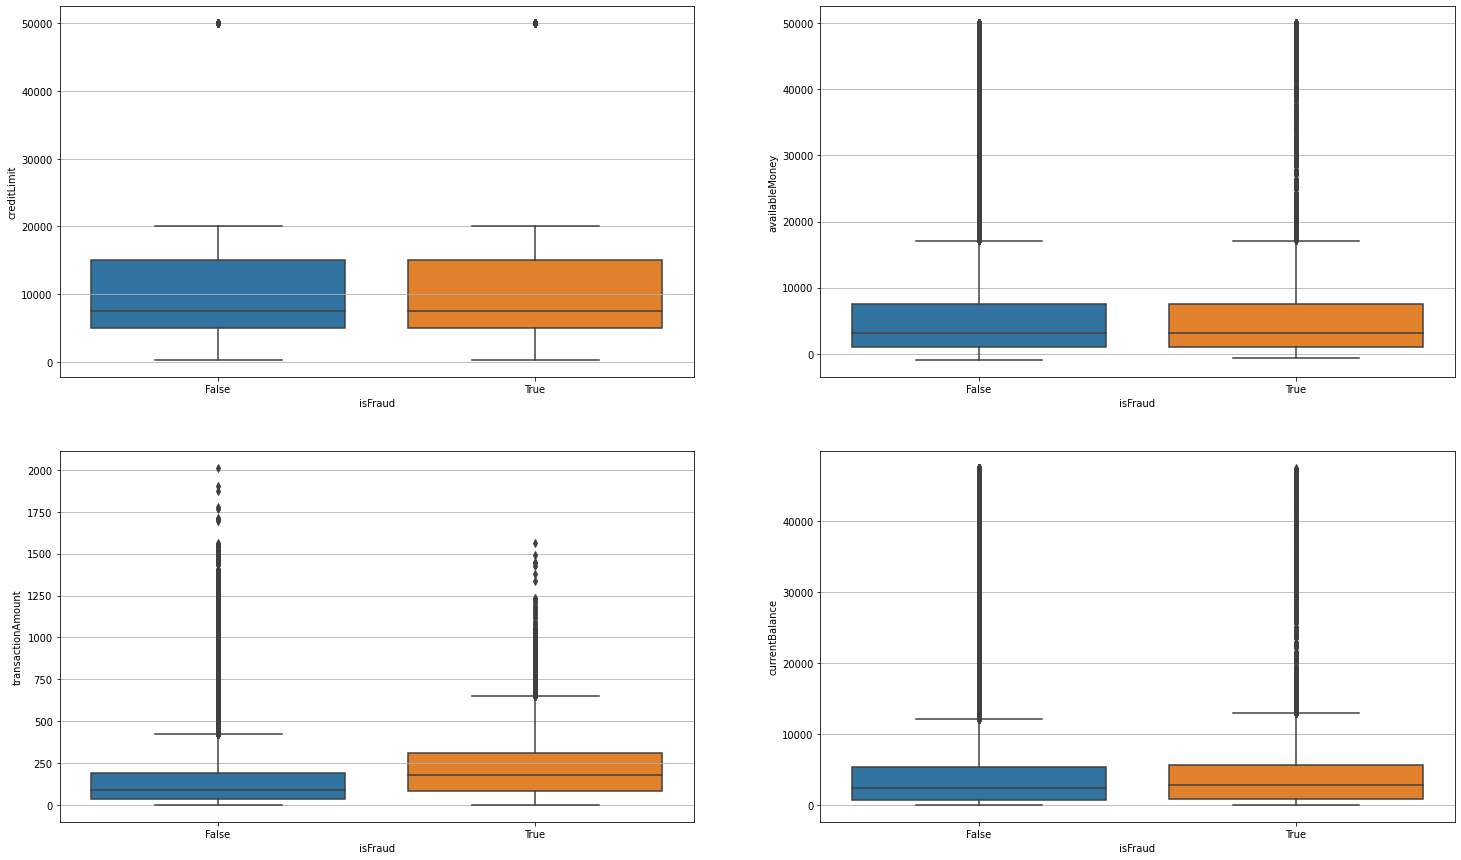

In [ ]:
#comparing the relationship of each numerical value with the target variable

dims = (2,2)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in num_cols:
  sns.boxplot(x='isFraud', y= col, data=train_df, ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0




*   Mean transaction amount is higher for fraud transactions as compared to Non-Fraud transactions.



## Categorical Columns Visualization

In [ ]:
obj_cols

['accountNumber',
 'customerId',
 'merchantName',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'cardCVV',
 'enteredCVV',
 'cardLast4Digits',
 'transactionType']

In [ ]:
bool_cols

['cardPresent', 'expirationDateKeyInMatch', 'isFraud']

### Univariate Analysis

In [ ]:
a = ['merchantName','acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent', 'expirationDateKeyInMatch']

train_df[a].nunique()

merchantName                2490
acqCountry                     4
merchantCountryCode            4
posEntryMode                   5
posConditionCode               3
merchantCategoryCode          19
transactionType                3
cardPresent                    2
expirationDateKeyInMatch       2
dtype: int64

**visualize the countplots for these numerical cols except merchaName**

In [ ]:
train_df.merchantName.value_counts()*100/len(train_df.merchantName)

Uber                             3.263444
Lyft                             3.257880
oldnavy.com                      2.164078
alibaba.com                      2.158197
staples.com                      2.151203
                                   ...   
Sprint Communications #561941    0.000318
TMobile Wireless #602341         0.000159
Boost Mobile #104815             0.000159
EZ Wireless #149871              0.000159
Curves #849125                   0.000159
Name: merchantName, Length: 2490, dtype: float64

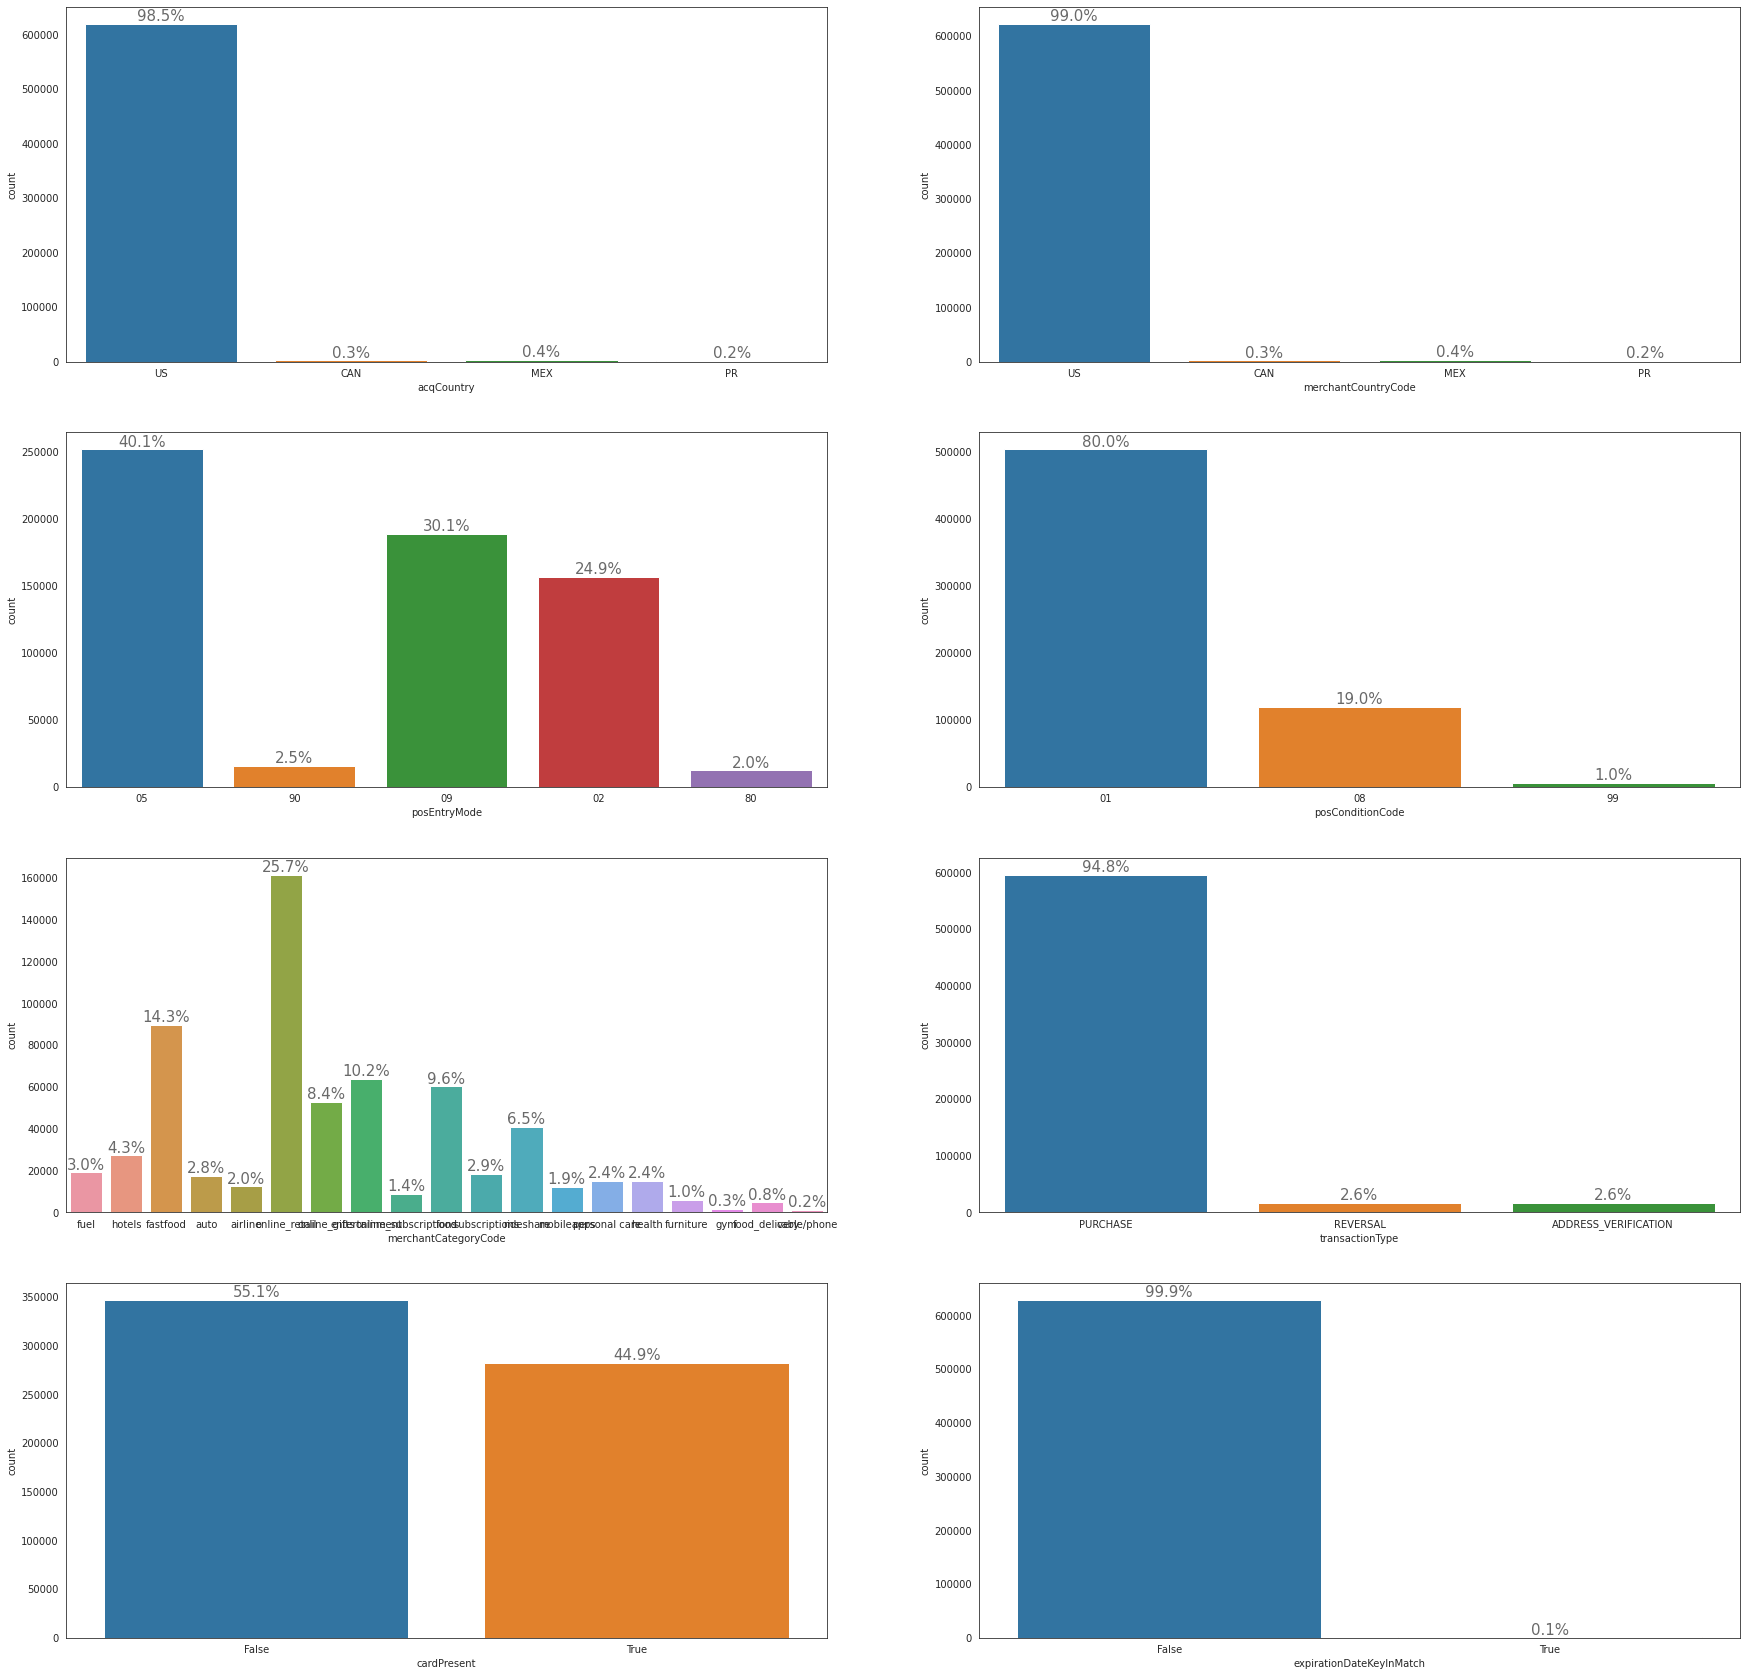

In [ ]:
#Visualzing the % of different levels in categorical variables

a = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent', 'expirationDateKeyInMatch']

sns.set_style(style='white')
dims = (4,2)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(30, 30))
axis_i, axis_j = 0, 0
for col in a:
  # Set few variables
  ncount = len(train_df[col])
  ax = sns.countplot(x=col,data=train_df, ax=axes[axis_i, axis_j])

  for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va = 'bottom', fontsize=15,color='dimgrey')
      
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0




*   This univariate analysis helps in. deciding the type of feature encoding to use for a categotrical variable in tree based models. 
*   Since all of them (except CardPresent are skewed), we can use ordinal encoding for all (except CardPresent) in tree based models
*   Majority of the customers and merchants are from US
*   Majority of the transactions have 01 as pos condition code (which means that the cardholder is not present)
*   Around 95 % of the transactions are purchase transactions
*   For about half (55%) of the transactiions card is not present
*   Almost for all the transactions, the expirationDatekeyInMatch is False

*   To intrepret the above insights more efficiently data dictionary is needed, but unfortunately that is not available




### Bivariate Analysis

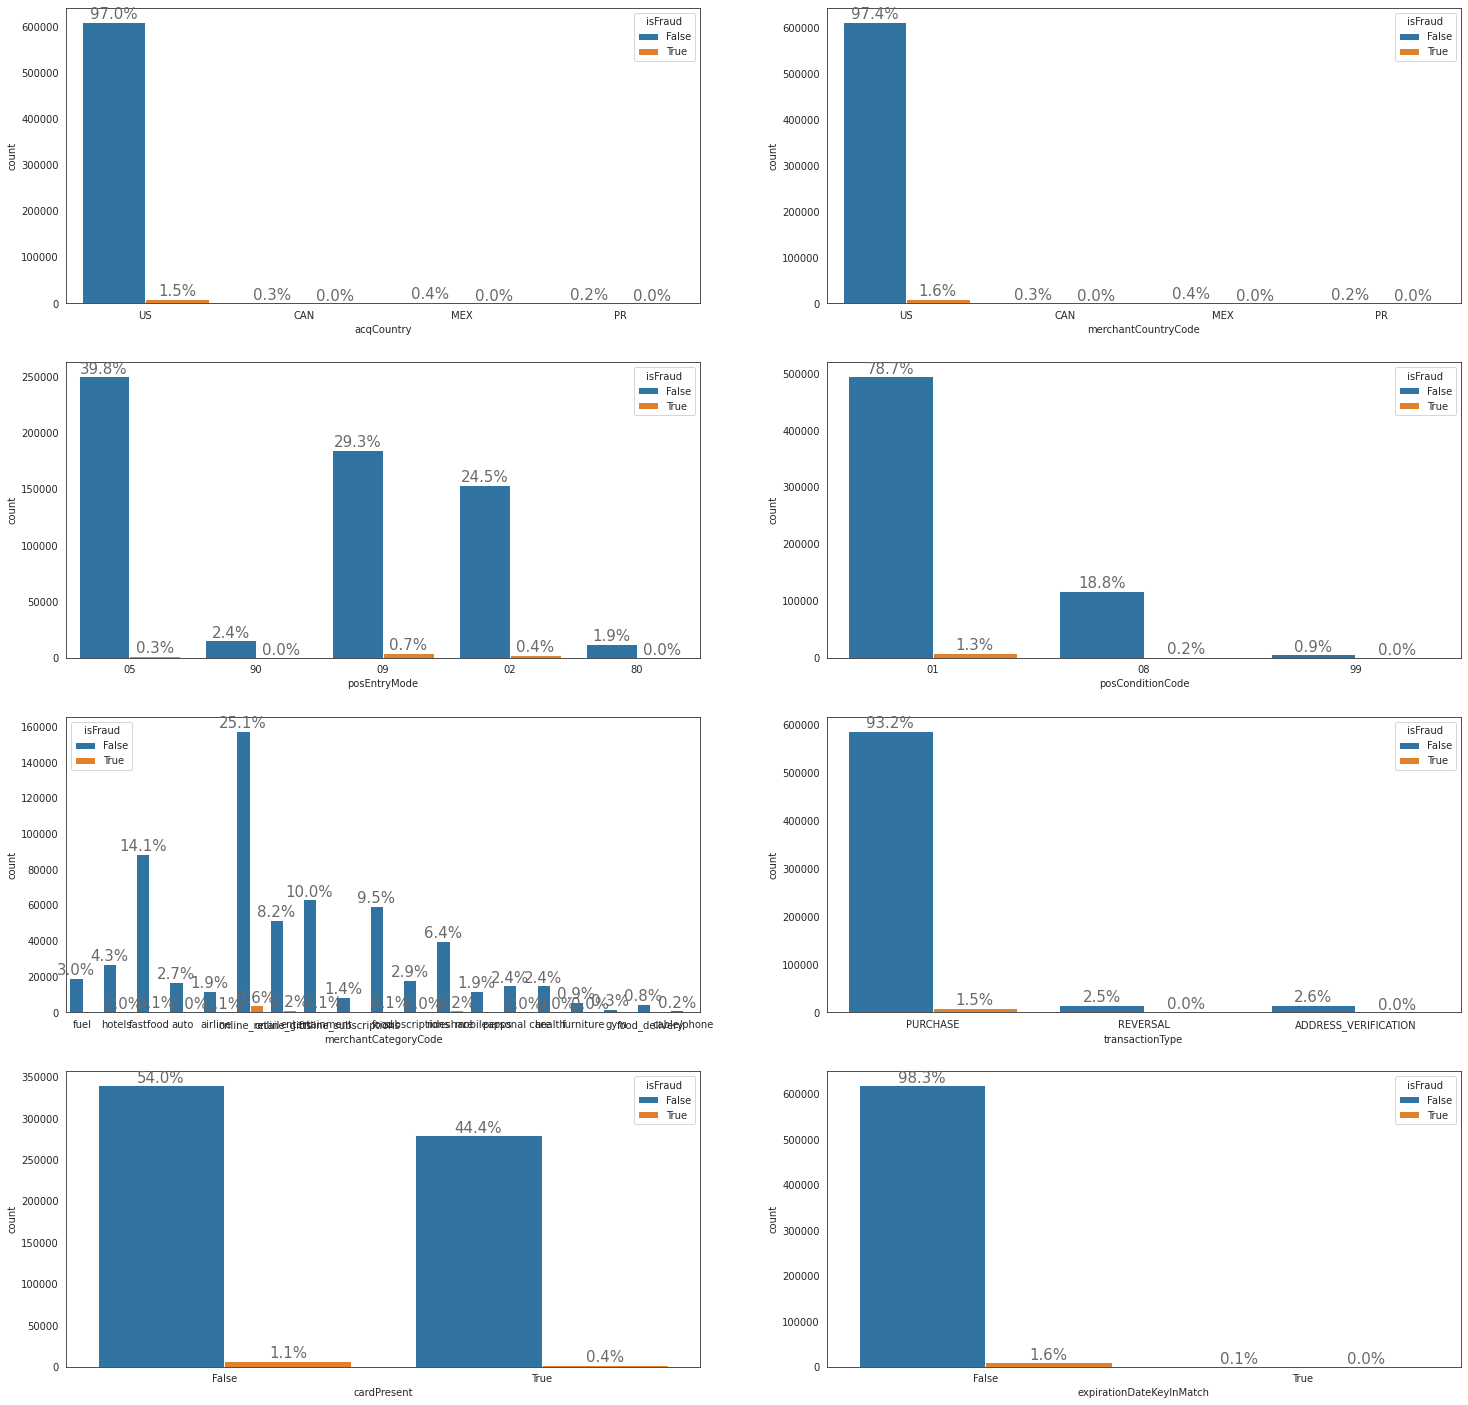

In [ ]:
#This can be deleted too#################
#bivariate analysis of categorical varibles with the target

a = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent', 'expirationDateKeyInMatch']

sns.set_style(style='white')
dims = (4,2)
 
f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 25))
axis_i, axis_j = 0, 0
for col in a:
  # Set few variables
  ncount = len(train_df[col])
  ax = sns.countplot(x=col,data=train_df, hue = 'isFraud',ax=axes[axis_i, axis_j])

  for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va = 'bottom', fontsize=15,color='dimgrey')
      
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In [ ]:
#the crosstab is used for cross tab proportion which is further used to prepare bivariate visualization
cross_tab_prop = pd.crosstab(index=train_df['acqCountry'],
                        columns=train_df['isFraud'],normalize = "index")
cross_tab_prop

isFraud,False,True
acqCountry,,
CAN,0.976816,0.023184
MEX,0.980135,0.019865
PR,0.980707,0.019293
US,0.984349,0.015651


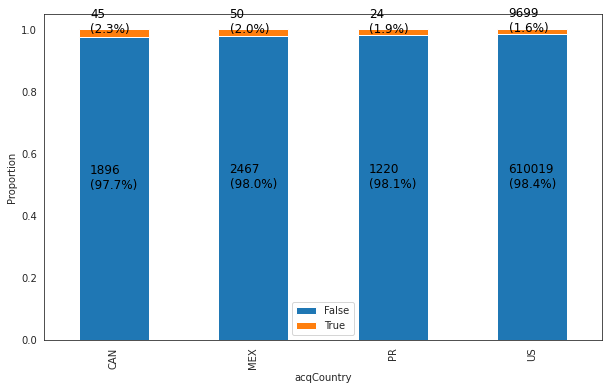

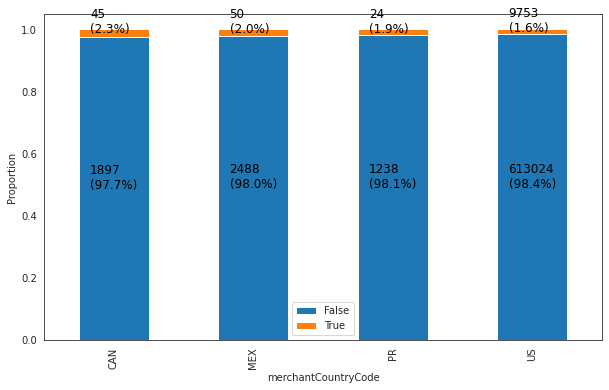

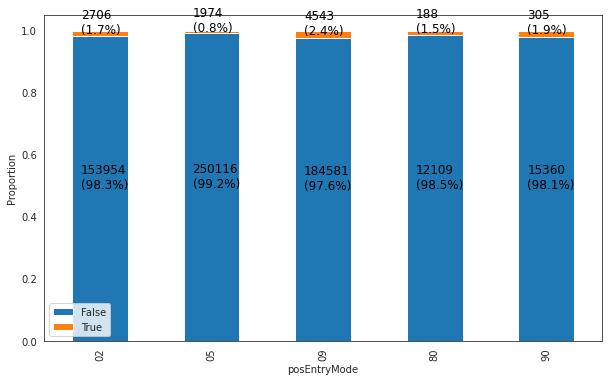

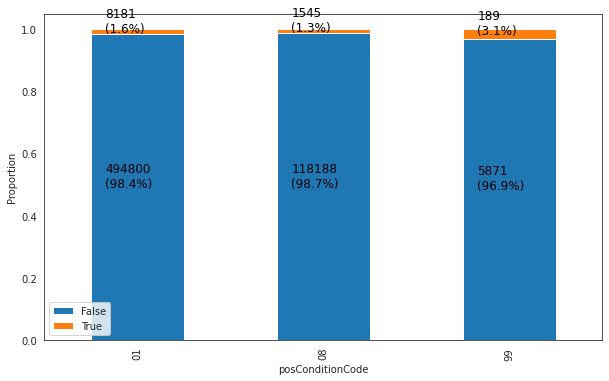

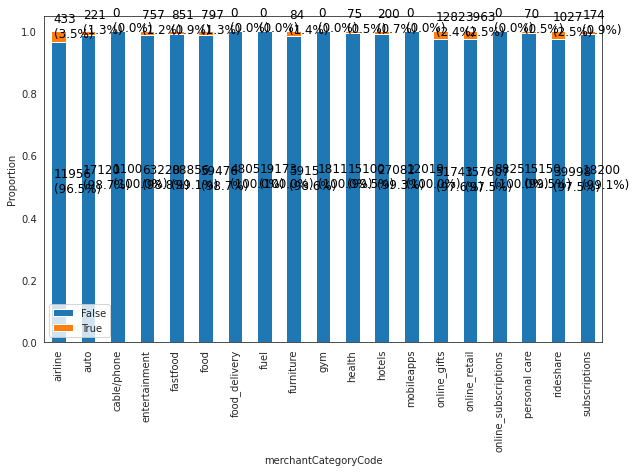

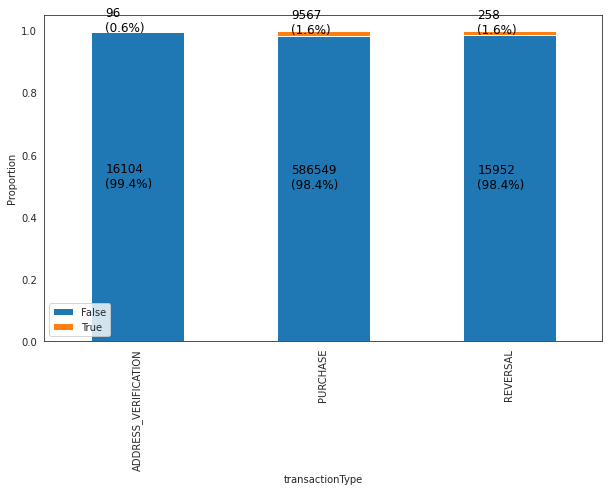

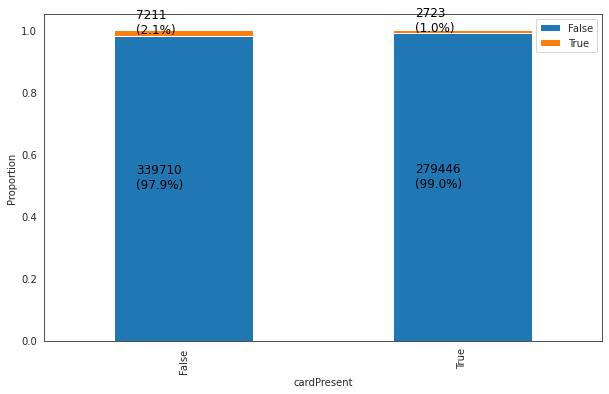

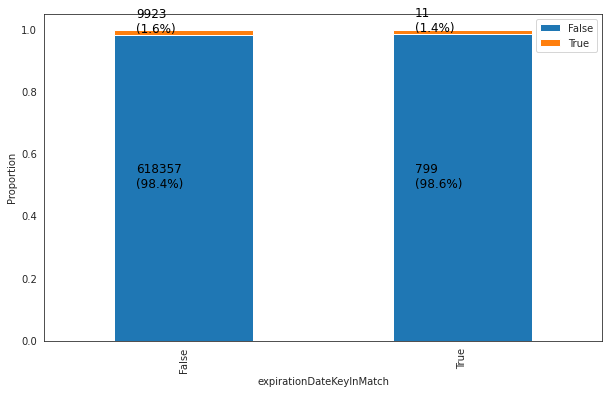

In [ ]:
a = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent', 'expirationDateKeyInMatch']

for col in a:
  cross_tab = pd.crosstab(index=train_df[col],columns=train_df['isFraud'])
  cross_tab_prop = pd.crosstab(index=train_df[col],columns=train_df['isFraud'],normalize = "index")

  cross_tab_prop.plot(kind='bar',stacked=True, figsize=(10, 6))

  plt.legend(loc="best")
  plt.ylabel("Proportion")


  for n, x in enumerate([*cross_tab.index.values]):
      for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                            cross_tab.loc[x],
                                            cross_tab_prop.loc[x].cumsum()):
                  
          plt.text(x=n - 0.17,y=(y_loc - proportion) + (proportion / 2),
                   s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                  color="black",
                  fontsize=12)

plt.show()



*   % of fraud transactions does not vary that much aross acqcountry and merchantcountrycode
*   09 posentrymode has highest fraud transactions (2.4%), whereas 05 has the lowest fraud transactions (0.8%)
*   99 poscondition code has the highest fraud transactions (3.1 %) across all the condition codes
*   Purchase and reverse transactions have the same % of fraud transactions. Address verification transaction has very low fraud transactions (0.6 %)
*   Transactions where card is not present has higher fraud (2.1 %) vs. when the card is present (1.0 %)
*   % of fraud transactions does not vary that much with expirationDatekeyinmatch



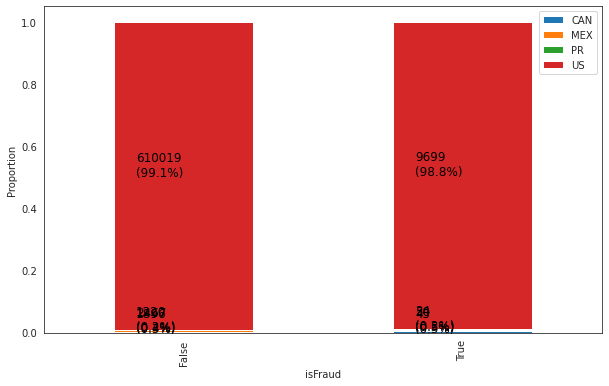

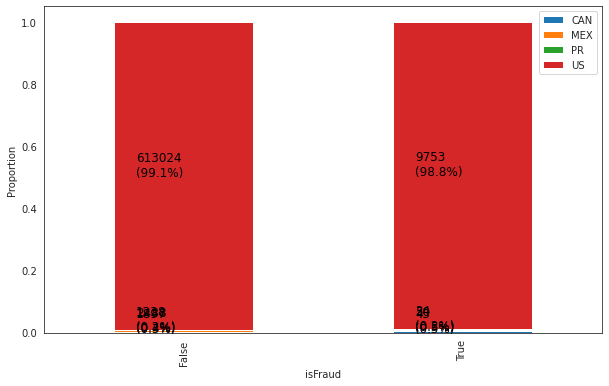

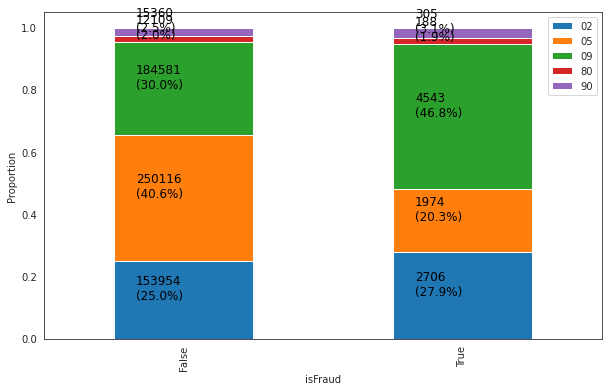

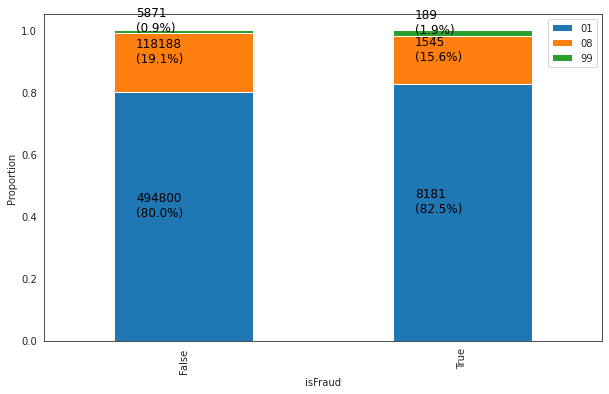

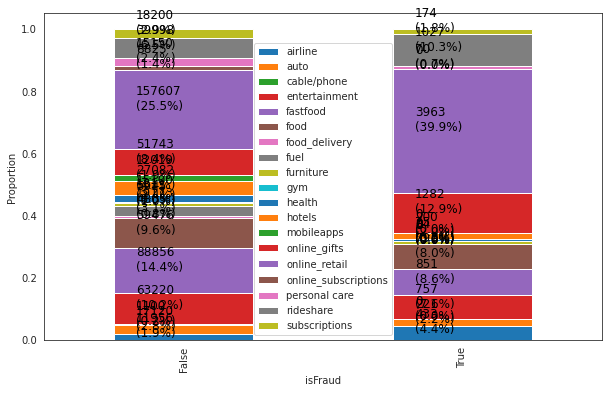

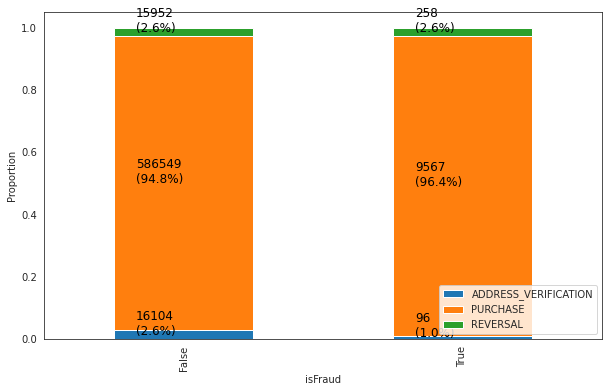

In [ ]:
a = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType']

for col in a:
  cross_tab = pd.crosstab(index=train_df['isFraud'],columns=train_df[col])
  cross_tab_prop = pd.crosstab(index=train_df['isFraud'],columns=train_df[col],normalize = "index")

  cross_tab_prop.plot(kind='bar',stacked=True, figsize=(10, 6))

  plt.legend(loc="best")
  plt.ylabel("Proportion")


  for n, x in enumerate([*cross_tab.index.values]):
      for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                            cross_tab.loc[x],
                                            cross_tab_prop.loc[x].cumsum()):
                  
          plt.text(x=n - 0.17,y=(y_loc - proportion) + (proportion / 2),
                   s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                  color="black",
                  fontsize=12)

plt.show()

In [ ]:
#creating a new feature CVV match and visualizing the % fraud with this feature
train_df['CVV_match'] = train_df['cardCVV'] == train_df['enteredCVV']

In [ ]:
train_df['CVV_match'].value_counts()

True     623502
False      5588
Name: CVV_match, dtype: int64

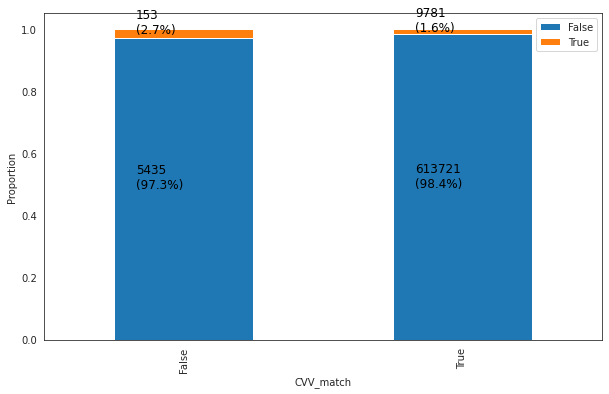

In [ ]:
a = ['CVV_match']

for col in a:
  cross_tab = pd.crosstab(index=train_df[col],columns=train_df['isFraud'])
  cross_tab_prop = pd.crosstab(index=train_df[col],columns=train_df['isFraud'],normalize = "index")

  cross_tab_prop.plot(kind='bar',stacked=True, figsize=(10, 6))

  plt.legend(loc="best")
  plt.ylabel("Proportion")


  for n, x in enumerate([*cross_tab.index.values]):
      for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                            cross_tab.loc[x],
                                            cross_tab_prop.loc[x].cumsum()):
                  
          plt.text(x=n - 0.17,y=(y_loc - proportion) + (proportion / 2),
                   s=f'{count}\n({np.round(proportion * 100, 1)}%)', 
                  color="black",
                  fontsize=12)

plt.show()
      

*   When CVV does not match,the chances of fraud is a bit high (2.7 % vs. 1.6%)

In [ ]:
#dropping this for now and as it's part of feature engineering
train_df.drop('CVV_match',axis = 1,inplace=True)

In [ ]:
# Checking top 20 merchants with highest numbers of fraud
import seaborn as sns
fraud_transactions_only = train_df[train_df['isFraud'] == True]

top_20_fraud_merchantname = ((fraud_transactions_only['merchantName'].value_counts(sort=True,normalize=True))*100).head(20)

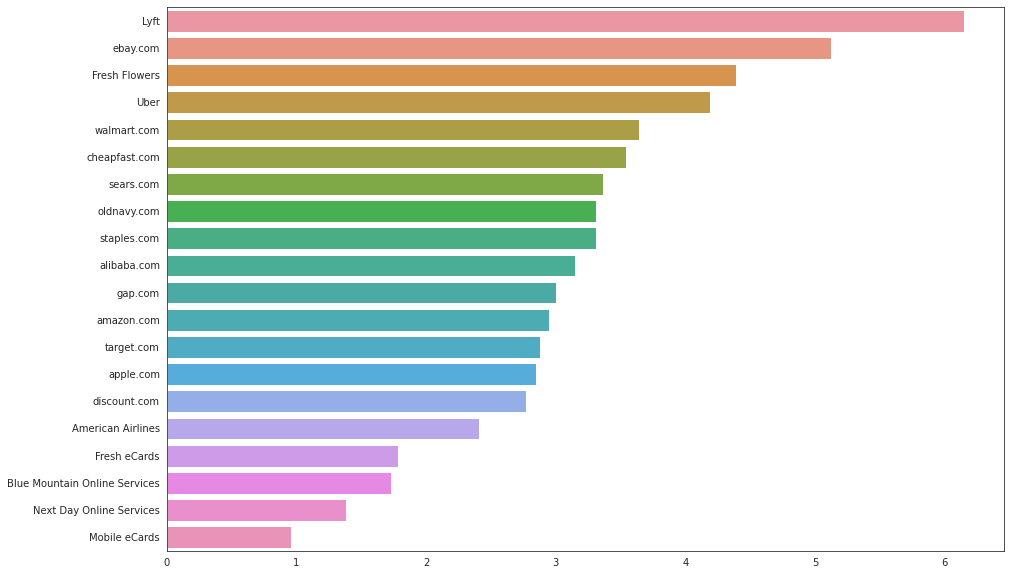

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.barplot(y=top_20_fraud_merchantname.index, x=top_20_fraud_merchantname.values, orient='h')
plt.show()

*   % of fraud is higher are for online merchants 

In [ ]:
# Checking top 20 account with highest numbers of fraud

fraud_transactions_only = train_df[train_df['isFraud'] == True]

top_20_fraud_accountNumber = ((fraud_transactions_only['accountNumber'].value_counts(sort=True,normalize=True))*100).head(20)

In [ ]:
top_20_fraud_accountNumber

380680241    6.271391
782081187    2.405879
700725639    2.264949
472288969    2.174351
246251253    2.103886
208319653    1.721361
419709514    1.600564
794398270    1.167707
369308035    1.087175
132629755    1.016710
269616174    0.865714
374358603    0.855647
882815134    0.805315
654507597    0.765049
307632490    0.664385
832842201    0.644252
937269523    0.624119
955678177    0.573787
148207119    0.573787
247130864    0.543588
Name: accountNumber, dtype: float64

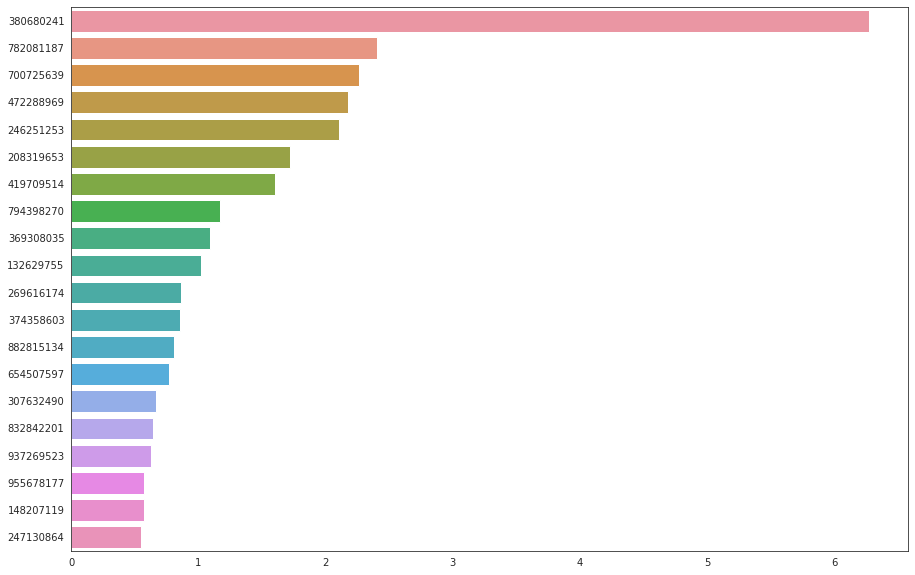

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,10))
sns.barplot( x=top_20_fraud_accountNumber.values, 
            y=top_20_fraud_accountNumber.index, 
            orient='h',
            order = top_20_fraud_accountNumber.index)
plt.show()

*   Account Number = 380680241 is contributing to 6% of the fraud transactions 

Account Number = 380680241 has done most frauds on Fresh Flowers merchant and when card was not present. 
